# 映画レビューの二値分類
（）

## IMDbデータセット
映画レビューのテキストの内容に基づいて、映画レビューを肯定的なレビューと否定的なレビューに分類する

In [1]:
## numpy==1.17.3などだとFuture warningが出まくるのでnumpy=1.16.4くらいにすると良い
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


データの確認

In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

num_words=10000で出現頻度が高い10000語の単語だけを残す。

In [4]:
max([max(sequence) for sequence in train_data])

9999

単語のシーケンスをエンコードしてリストにする。


In [5]:
# word_indexは単語を整数のインデックスにマッピングする。
word_index = imdb.get_word_index()
# dictは整数のインデックスを単語にマッピングする。
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# レビューをデコードする。
# 0, 1, 2はそれぞれ「パディング」「シーケンス開始」「不明」のインデックスとして予約されているので、
# インデックスオフセットを3にして0, 1, 2を使用しないようにする。
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [6]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## データの準備

インデックス化されたレビューをテンソルに変換する。
ここではone-hotエンコーディングを使ってリストを0と1のベクトルに変換する。

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 形状が (len(sequences), dimension)の0行列を生成
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# 訓練データのベクトル化
x_train = vectorize_sequences(train_data)
# テストデータのベクトル化
x_test = vectorize_sequences(test_data)

サンプルは以下のように表示される。

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

ラベルもベクトル化しておく必要があります。

In [9]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## ニューラルネットワークの構築

入力はベクトルでラベルはスカラー（0か1）なのでここでは全結合層のネットワークとReLU (Rectified Linear Unit)活性化関数で構成されたネットワークが適切である:
`Dense(16, activation='relu')`

Dense層に渡される引数（16）→ 層の隠れユニットの数。

`output = relu(dot(W, input) + b)`

16個の隠れユニットを持つということは重み行列Wの形状は（input_dimension, 16）になるということ。隠れユニットが増えてより高次元の表現空間になるほど、ネットワークは複雑な表現を学習でできるようになる。（ただし、計算量も増えてしまう）
There are two key architecture decisions to be made about such stack of dense layers:

Dense層のアーキテクチャ上の重要な意思決定が２つ必要になる。
- 使用する層の数をいくつにするか
- 各層の隠れユニットの数をいくつにするか

ここでは以下のように決定する。
- 16の隠れユニットを持つ２つの中間層
- 現在のレビューの感情に関する予測値（スカラー）を出力する３つ目の層を与える。

今回のネットワーク構成:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

### モデルの定義

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
# モデルのサマリを表示
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


この問題は二値分類問題であり、ネットワークの出力は確率であるため損失関数には二値の交差エントロピーを選択するのが適切。

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 独自にオプティマイザや損失関数を設定したいとき
オプティマイザのパラメータを設定したり、独自の損失関数や指標関数を指定する必要がある場合には、以下のようにoptimizer、loss、metricsパラメータの引数を使って指定する。

In [13]:
# from keras import optimizers

# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [14]:
# from keras import losses
# from keras import metrics

# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

## アプローチの検証

データセットをトレーニングセットとテストデータセットに分ける。

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### モデルを訓練する
トレーニングセットの512サンプルのバッチデータで20エポックの訓練（20回の訓練）を行う。
検証データはvlidation_dataに指定して格納。

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 238us/step - loss: 0.5367 - accuracy: 0.7805 - val_loss: 0.4177 - val_accuracy: 0.8590
Epoch 2/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.3272 - accuracy: 0.8979 - val_loss: 0.3180 - val_accuracy: 0.8844
Epoch 3/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.2384 - accuracy: 0.9257 - val_loss: 0.2810 - val_accuracy: 0.8923
Epoch 4/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.1870 - accuracy: 0.9401 - val_loss: 0.2786 - val_accuracy: 0.8881
Epoch 5/20
15000/15000 [==============================] - 2s 148us/step - loss: 0.1523 - accuracy: 0.9507 - val_loss: 0.2739 - val_accuracy: 0.8914
Epoch 6/20
15000/15000 [==============================] - 2s 122us/step - loss: 0.1246 - accuracy: 0.9616 - val_loss: 0.2832 - val_accuracy: 0.8882
Epoch 7/20
15000/15000 [==============================] - 2s 

historyは訓練中に起きた全てのことに関するデータを含む辞書。
辞書の内容を見てみよう。

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

訓練中の損失値をプロットしてみよう

findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans.


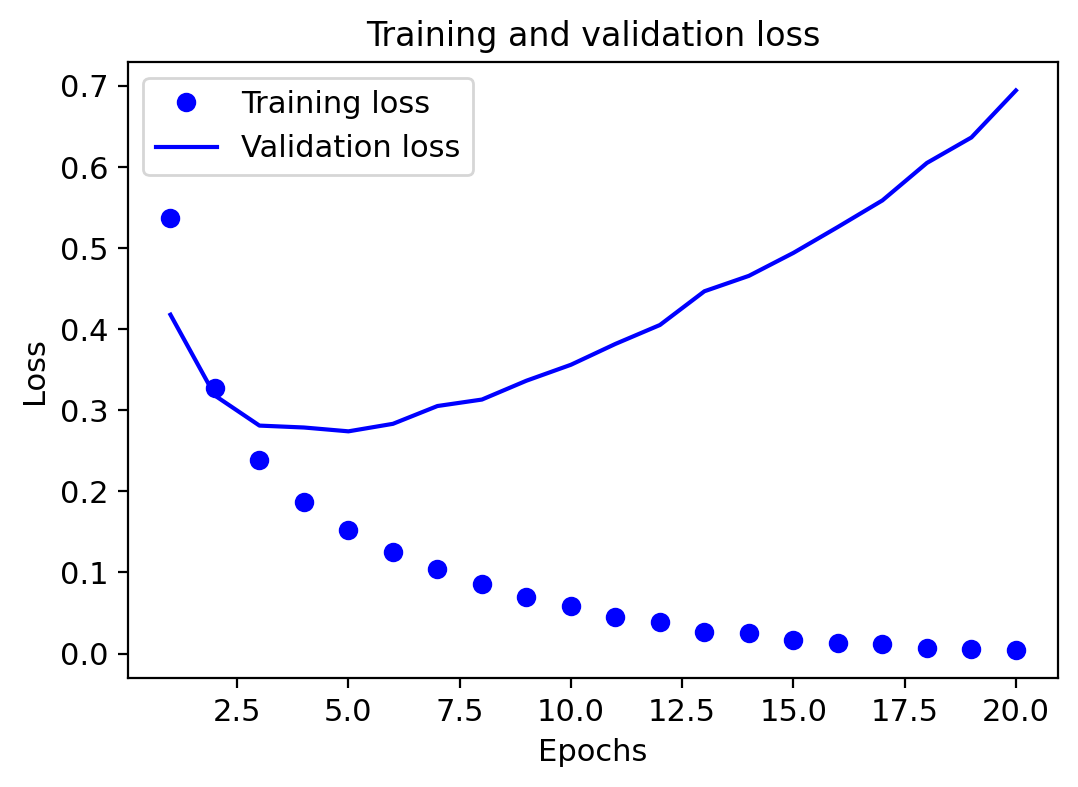

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

トレーニングセットとテストデータセットでの正解率をプロットしてみよう

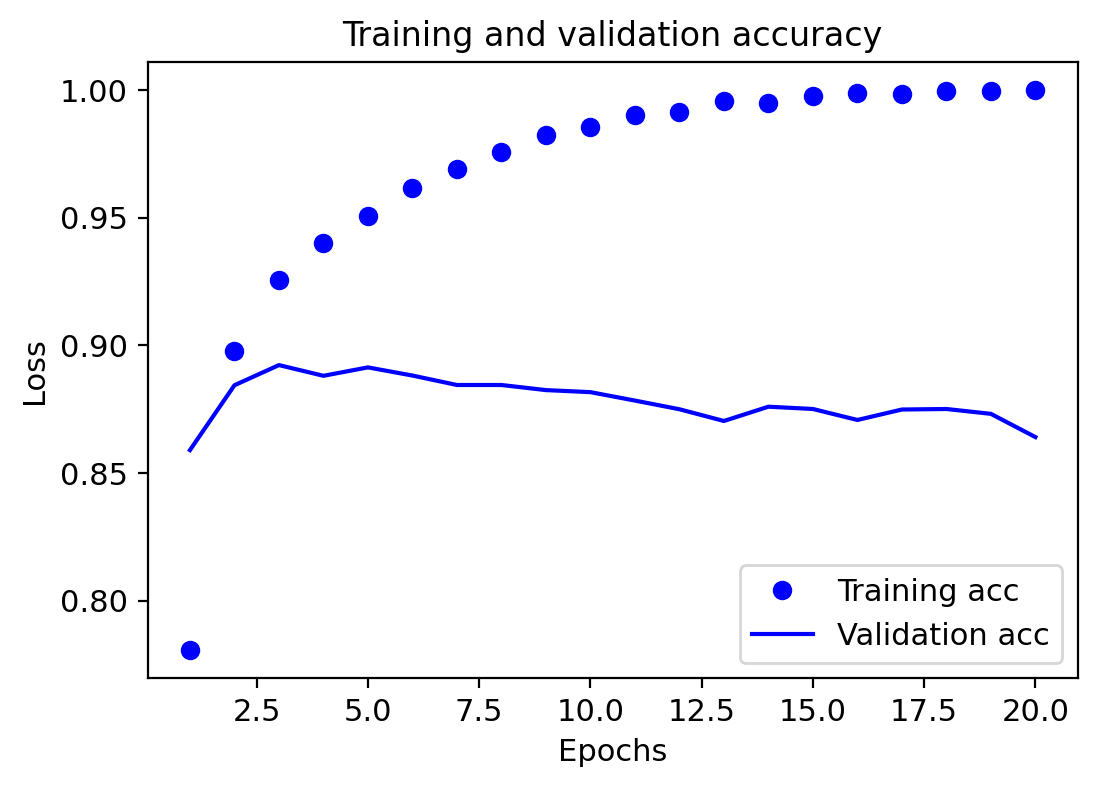

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

トレーニングデータでの損失値がエポックごとに小さくなっていき、正解率が向上していることがわかる。
一方、テストデータセットに対しては、4つ目のエポックで損失値はそこを打ち正解率もピークに達している様子が見てとれる。
これは過学習（overfitting）が起きていることを示している。

したがって、今回は過学習を回避するために訓練回数（エポック）を3回で止めるのが適当であろう。

新しいモデルでは訓練回数（エポック）を4回にしてみよう。

In [23]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 7s 260us/step - loss: 0.4608 - accuracy: 0.8155
Epoch 2/4
25000/25000 [==============================] - 3s 134us/step - loss: 0.2678 - accuracy: 0.9096
Epoch 3/4
25000/25000 [==============================] - 5s 207us/step - loss: 0.2059 - accuracy: 0.9275
Epoch 4/4
25000/25000 [==============================] - 3s 139us/step


In [46]:
results

[0.32325289717674255, 0.87344]

## 学習済みネットワークで新しいデータで予測値を生成する

訓練が完了したらpredictメソッドを呼び出してレビューが肯定的として分類される尤度を生成する。

In [24]:
model.predict(x_test)

array([[0.15688038],
       [0.99885744],
       [0.84781396],
       ...,
       [0.07715628],
       [0.05715117],
       [0.5548967 ]], dtype=float32)

確実に分類できそうなサンプル（0.99以上や0.05以下）もありますが、確実に分類できなさそうなサンプル（0.55など）もあるようです。